In [1]:
import torch
from torchvision.models import DenseNet121_Weights
import torchvision.models as models
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torch.utils.data import random_split
# from CustomDataset import CustomDataset
import matplotlib.pyplot as plt
import random
from PIL import Image
from tqdm.auto import tqdm
import os
import pandas as pd

In [2]:
#Device Agnostic Code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch

#TO-DO One Hot encoding for labels

class XRayDataset(Dataset):
            def one_hot_encode(self,data):
                """Function to one hot encode the labels."""
                 #Spliting the labels
                labels = [i.split('|') for i in data['Finding Labels']]

                #Get unique labels
                self.unieque_labels = list(set(j for i in labels for j in i))

                #Creating Dataframe
                df = pd.DataFrame(0, index = range(len(data)), columns= self.unieque_labels)

                #Assigning 1 in corresponding colunms 
                for i,label in enumerate(labels):
                    df.loc[i, label] = 1
                    
                df = pd.concat([data['Image Index'], df], axis = 1)
                
                return df
            
            def show(self):
                print(self.data)
            
            def __init__(self, csv_file, root_dir, transform=None):
                self.data = pd.read_csv(csv_file)
                self.data = self.data[['Image Index', 'Finding Labels']]
                
                self.data = self.one_hot_encode(self.data)
                
                self.root_dir = root_dir
                self.transform = transform
                
                self.classes = self.unieque_labels
                self.label_idx = dict(enumerate(self.classes))

            def __len__(self):
                return len(self.data)

            def __getitem__(self, idx):
                img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
                image = Image.open(img_name)
                if self.transform:
                    image = self.transform(image)
                    
                
                label = [i for i in range(len(self.classes)) if self.data.iloc[idx,i] == 1]
                if list(label) == []:
                    label = torch.tensor(0)
                else:
                    label = torch.tensor(random.choice(label))
                
                

                return image, label

            
                

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(),
    # transforms.RGB(),
    transforms.ToTensor()
])

In [5]:

root_dir = r'Dataset\Image'
csv_file = r'Dataset\Data_entry_2017.csv'

dataset = XRayDataset(csv_file=csv_file, root_dir=root_dir,transform=transform)

dataset.show()
print(dataset.unieque_labels)

#Splittig Data
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create datasets and loaders

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



             Image Index  No Finding  Mass  Pneumonia  Nodule  \
0       00000001_000.png           0     0          0       0   
1       00000001_001.png           0     0          0       0   
2       00000001_002.png           0     0          0       0   
3       00000002_000.png           1     0          0       0   
4       00000003_000.png           0     0          0       0   
...                  ...         ...   ...        ...     ...   
112115  00030801_001.png           0     1          1       0   
112116  00030802_000.png           1     0          0       0   
112117  00030803_000.png           1     0          0       0   
112118  00030804_000.png           1     0          0       0   
112119  00030805_000.png           1     0          0       0   

        Pleural_Thickening  Atelectasis  Edema  Hernia  Pneumothorax  \
0                        0            0      0       0             0   
1                        0            0      0       0             0   
2  

In [6]:
len(dataset.classes)
dataset.label_idx

{0: 'No Finding',
 1: 'Mass',
 2: 'Pneumonia',
 3: 'Nodule',
 4: 'Pleural_Thickening',
 5: 'Atelectasis',
 6: 'Edema',
 7: 'Hernia',
 8: 'Pneumothorax',
 9: 'Cardiomegaly',
 10: 'Consolidation',
 11: 'Infiltration',
 12: 'Fibrosis',
 13: 'Emphysema',
 14: 'Effusion'}

In [7]:
random_img = random.choice(os.listdir('Dataset\Image'))



In [8]:
#Hyper Parmaeters
lr = 0.01
epochs = 5


In [9]:
#Ressnet Model
# model = models.resnet50(pretrained = True)
# pretrained_weights = model.conv1.weight.clone()

# Create a new layer with 1 input channel
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 15) 

In [10]:
#Denesnet Model
class DenseNet169(nn.Module):

    def __init__(self, num_classes):
        super(DenseNet169, self).__init__()

        #Load pre-trained DenseNet-169 model
        self.densenet169 = models.densenet169(weights=True)

        #Modify the classifier to match the number of classes
        # model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        in_features = self.densenet169.classifier.in_features
        self.densenet169.classifier = nn.Linear(in_features, num_classes)
        self.densenet169.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    def forward(self, x):
        x = self.densenet169(x)
        return x

model = DenseNet169(15)

# model = model.load_state_dict(torch.load('Model/XRayresenet5k.pth'))

model.to(device)

c:\Users\swast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet169(
  (densenet169): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [11]:
#Loss_fn and Optimizer
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

In [13]:
# Training Loop 
torch.cuda.random.manual_seed(42)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}/{epochs}")
    loss_values = []
    
    for batch_idx,(img,label) in enumerate(tqdm(train_dataloader)):
        img = img.to(device)
        label = label.to(device)
        
        # print(label)
        
        pred = model(img)  
        
        loss = loss_fn(pred,label)
        loss_values.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
    print(f"Loss: {loss.item()}")
    #Saving Model
    PATH = f'Model/XRayDenseNet169_120k_{epoch}.pth'
    torch.save(model.state_dict(),f = PATH)
    print(f"Model Succesffully Saved at {PATH}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0/5


  0%|          | 0/2803 [00:00<?, ?it/s]

Loss: 1.886608600616455
Model Succesffully Saved at Model/XRayDenseNet169_120k_{epoch}.pth
Epoch: 1/5


  0%|          | 0/2803 [00:00<?, ?it/s]

Loss: 1.889717698097229
Model Succesffully Saved at Model/XRayDenseNet169_120k_{epoch}.pth
Epoch: 2/5


  0%|          | 0/2803 [00:00<?, ?it/s]

Loss: 1.2788922786712646
Model Succesffully Saved at Model/XRayDenseNet169_120k_{epoch}.pth
Epoch: 3/5


  0%|          | 0/2803 [00:00<?, ?it/s]

Loss: 1.6323672533035278
Model Succesffully Saved at Model/XRayDenseNet169_120k_{epoch}.pth
Epoch: 4/5


  0%|          | 0/2803 [00:00<?, ?it/s]

Loss: 2.014512538909912
Model Succesffully Saved at Model/XRayDenseNet169_120k_{epoch}.pth


In [15]:
#Accuracy fn

def accuracy(loader,model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.inference_mode():
        for x,y in tqdm(loader):
            x = x.to(device = device)
            y = y.to(device = device)
            
            scores = model(x)
            # print(scores)
            _,predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
        
    model.train()

# accuracy(train_dataloader,model)
accuracy(test_dataloader,model)

  0%|          | 0/701 [00:00<?, ?it/s]

Got 11926 / 22424 with accuracy 53.18


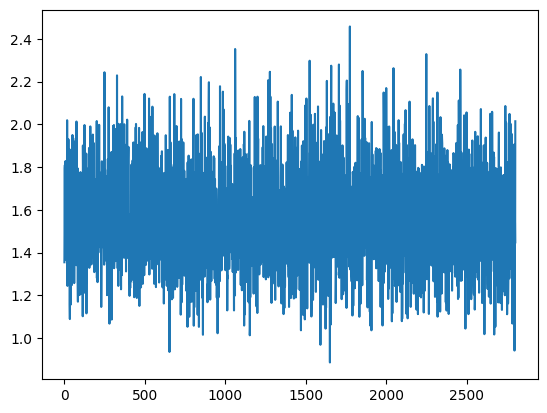

In [16]:
#Plotting Loss
plt.plot(loss_values);


In [17]:
#Saving Model
PATH = 'Model/XRayDenseNet169_120k_final.pth'
torch.save(model.state_dict(),f = PATH)
print(f"Model Succesffully Saved at {PATH}")

Model Succesffully Saved at Model/XRayDenseNet169_120k_final.pth
